In [1]:
import os.path as path
import math
import skimage.io as io
import numpy as np
import scipy as sp
import skimage
from skimage import color
from skimage import util
import skimage.filters as filters
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy import signal
from scipy.interpolate import interp1d
from skimage import color
import cv2
from sksparse.cholmod import cholesky,cholesky_AAt
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

from task4_grad_domain import img2grad_field, reconstruct_grad_field


#https://github.com/yig/PySPQR
import sparseqr

## Step 1: Imaging Operator - Gradient Domain Optimisations

Define a image operator, which will be used to apply to the down-sampled input image. The low resolution Input/Output image produced will be used to fit an bilateral grid of affine models. 

In [160]:
def optGrad(im):
    im = skimage.img_as_float(im)

    im_gray = color.rgb2gray(im)

    G = img2grad_field(im_gray)

    x_in = 0.4
    m = 2

    x = np.arange(-2.0, 2.0, 0.1)
    y = m*x
    f1 = interp1d(x, y)

    m2 = (m*x_in -1)/(x_in - 1)
    y2 = m2*x + (1-m2)
    f2 = interp1d(x, y2)

    G_enhanced = np.zeros(G.shape)
    G_enhanced = np.where(G < x_in, f1(G), f2(G))

    print("No. of pixels: ", G.shape[0]*G.shape[1])

    Gm = np.sqrt(np.sum(G_enhanced*G_enhanced, axis=2))
    w = 1/(Gm + 0.0001)     # to avoid pinching artefacts
    imr = reconstruct_grad_field(G_enhanced,w,im_gray[0,0], im_gray, "cholesky").clip(0,1)
#     imr = reconstruct_grad_field(G_enhanced,w,im_gray[0,0], im_gray, "sp").clip(0,1)

    imr_col = im.copy()
    c = imr/(im_gray+ 0.0001) # 0.0001 to avoid diversion by 0
    for i in range(0,3):
        imr_col[:,:,i] = im[:,:,i]*c
    
    result = np.round(imr_col.clip(0,1)*255).astype('uint8')
#     result = imr_col

    plt.figure(figsize=(9, 3))

    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(im)

    plt.subplot(122)
    plt.title('Enhanced')
    plt.axis('off')
    plt.imshow(result[:,:,:])

    plt.show()
    
    return result

No. of pixels:  3932160
cholesky  time: 27.407591581344604


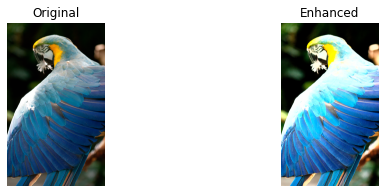

No. of pixels:  61440
cholesky  time: 0.1156306266784668


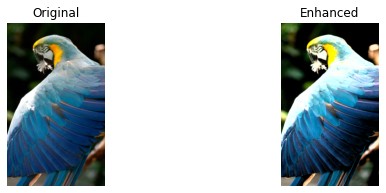

In [162]:
highr_input_image = io.imread(path.join('images','high_res_in.png'))
highr_output_image = optGrad(highr_input_image)

highr_input_edge_image  = cv2.cvtColor(highr_input_image, cv2.COLOR_BGR2GRAY)
highr_input_edge_image  = cv2.normalize(highr_input_edge_image,highr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

lowr_input_image = io.imread(path.join('images','low_res_in.png'))
lowr_output_image = optGrad(lowr_input_image)

lowr_input_edge_image  = cv2.cvtColor(lowr_input_image, cv2.COLOR_BGR2GRAY)
lowr_input_edge_image  = cv2.normalize(lowr_input_edge_image,lowr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

grid_size = [20,15,10,4,3]

## Step 2: Fit Affine model
Fitting a bilateral grid of affine models to the low resolution Input/Output pair
- Contruct bilateral grid: https://people.csail.mit.edu/sparis/publi/2007/siggraph/Chen_07_Bilateral_Grid.pdf
- matching reconstruction(trilinear) filter can be expressed as  StBSx: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/44003.pdf
- affine matrices:
https://people.csail.mit.edu/sparis/publi/2009/sigasia/Bousseau_09_User-assisted_Intrinsic_Images.pdf

In [56]:
# highr_input_image = io.imread(path.join('images','high_res_in.png'))
# highr_output_image = io.imread(path.join('images','high_res_ground_truth_out.png'))


# highr_input_edge_image  = cv2.cvtColor(highr_input_image, cv2.COLOR_BGR2GRAY)
# highr_input_edge_image  = cv2.normalize(highr_input_edge_image,highr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

# lowr_input_image = io.imread(path.join('images','low_res_in.png'))
# lowr_output_image = io.imread(path.join('images','low_res_out.png'))

# lowr_input_edge_image  = cv2.cvtColor(lowr_input_image, cv2.COLOR_BGR2GRAY)
# lowr_input_edge_image  = cv2.normalize(lowr_input_edge_image,lowr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

# grid_size = [20,15,10,4,3]

### For each component in the affine model (i,j):
- Build the matrices that slices out a particular (i,j) component of the affine model stored in a 3D bilateral grid using trilinear interpolation.
- Total 12 components

#### weight matrix: 
Generate weight with guidance image
guided filter:http://kaiminghe.com/eccv10/

In [163]:
def getWeightMatrix(grid_size, input_img, arg_edge_img):

    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width)) * (grid_width-1)
    bg_coordy = ((pixel_y + 0.5)/(img_height)) * (grid_height-1)
    bg_coordz = edge_img * (grid_depth-1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z

    #compute dxdydz: distance of each point from the integeral bilateral grid coordinate
    dx = np.tile((bg_coordx - bg_int_x),(img_height, 1))
    dy = np.repeat((bg_coordy - bg_int_y).reshape(img_height,1),img_width,axis = 1)
    dz = bg_coordz - bg_int_z
    
    # Each weight_{x}{y}{z} is an image (height x width) ??
    w_000_temp = np.multiply ((1 - dx),(1 - dy))
    w_000 = np.multiply(w_000_temp,(1 - dz)).reshape(num_pixels)
    
    w_100_temp = np.multiply ((    dx),(1 - dy))
    w_100 = np.multiply(w_100_temp, (1 - dz)).reshape(num_pixels)
    
    w_010_temp = np.multiply ((1 - dx),(    dy))
    w_010 = np.multiply(w_010_temp,(1 - dz)).reshape(num_pixels)
    
    w_110_temp = np.multiply ((    dx),(    dy))
    w_110 = np.multiply(w_110_temp,(1 - dz)).reshape(num_pixels)
    
    w_001_temp = np.multiply ((1 - dx),(1 - dy))
    w_001 = np.multiply(w_001_temp,(    dz)).reshape(num_pixels)
    
    w_101_temp = np.multiply ((    dx),(1 - dy))
    w_101 = np.multiply(w_101_temp,(    dz)).reshape(num_pixels)
    
    w_011_temp = np.multiply ((1 - dx),(    dy))
    w_011 = np.multiply(w_011_temp,(    dz)).reshape(num_pixels)
    
    w_111_temp = np.multiply ((    dx),(    dy))
    w_111 = np.multiply(w_111_temp,(    dz)).reshape(num_pixels)
    
    w_i = np.tile(range(num_pixels),(8, 1)).reshape(num_pixels*8)
    w_j = np.array(range(num_pixels*8)).reshape(num_pixels*8) #sparse matrix y coordinate
    w_val = np.squeeze(np.concatenate([w_000,w_100,w_010,w_110,w_001,w_101,w_011,w_111]))
    w_m = num_pixels
    w_n = num_pixels*8
    
    weight = sparse.csr_matrix((w_val,(w_i,w_j)),
                 shape = (w_m,w_n))
    
    total_weight = sparse.block_diag((weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight))
    
    return total_weight

weight_matrix = getWeightMatrix(grid_size,lowr_input_image,lowr_input_edge_image)

# pd.DataFrame(weight_matrix.toarray()).to_csv("debug/weight.csv")

In [164]:
weight_matrix

<737280x5898240 sparse matrix of type '<class 'numpy.float64'>'
	with 5898240 stored elements in COOrdinate format>

#### slice matrix: 

In [165]:
def getSliceMatrix(grid_size, input_img, arg_edge_img):
    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width)) * (grid_width-1)
    bg_coordy = ((pixel_y + 0.5)/(img_height)) * (grid_height-1)
    bg_coordz = edge_img * (grid_depth-1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z
    
    st_indice = np.array(range(num_pixels*8))
    st_bg_x = np.concatenate(((bg_int_x_img + 0), (bg_int_x_img + 1),(bg_int_x_img + 0),(bg_int_x_img + 1), (bg_int_x_img + 0),(bg_int_x_img + 1),(bg_int_x_img + 0), (bg_int_x_img + 1))).reshape(num_pixels*8,1)
    st_bg_y = np.concatenate(((bg_int_y_img + 0), (bg_int_y_img + 0),(bg_int_y_img + 1),(bg_int_y_img + 1), (bg_int_y_img + 0),(bg_int_y_img + 0),(bg_int_y_img + 1), (bg_int_y_img + 1))).reshape(num_pixels*8,1)
    st_bg_z = np.concatenate(((bg_int_z_img + 0), (bg_int_z_img + 0),(bg_int_z_img + 0),(bg_int_z_img + 0), (bg_int_z_img + 1),(bg_int_z_img + 1),(bg_int_z_img + 1), (bg_int_z_img + 1))).reshape(num_pixels*8,1)
    
    #prune away indices that are out of bound of the grid cell
    indices = (st_bg_x >= 0) & (st_bg_x < grid_width) & (st_bg_y >= 0) & (st_bg_y < grid_height)& (st_bg_z >= 0) & (st_bg_z < grid_depth)
    indices = np.squeeze(indices)
    st_ii = st_indice[indices]
    st_bg_xx = st_bg_x[indices].astype(int)
    st_bg_yy = st_bg_y[indices].astype(int)
    st_bg_zz = st_bg_z[indices].astype(int)
    
        
    st_list = []
    for j in range(grid_affine_input_size):
        for i in range(grid_affine_output_size):
            st_bg_u = j * np.ones((num_pixels*8, 1))
            st_bg_v = i * np.ones((num_pixels*8, 1))
            st_s = np.ones((num_pixels*8, 1))

            
            st_bg_uu = st_bg_u[indices].astype(int)
            st_bg_vv = st_bg_v[indices].astype(int)
            
            st_val = st_s[indices].astype(int)#all ones
            
            st_jj_dim = [grid_width, grid_height, grid_depth, grid_affine_input_size, grid_affine_output_size]
            st_jj = np.ravel_multi_index([st_bg_xx, st_bg_yy, st_bg_zz, st_bg_uu, st_bg_vv], dims=st_jj_dim)
            
            
            st_val = np.squeeze(st_val)
            st_ii = np.squeeze(st_ii)
            st_jj = np.squeeze(st_jj)
            
            st_m = 8 * num_pixels
            st_n = num_grid_cells
            st = sparse.csr_matrix((st_val,(st_ii,st_jj)),shape = (st_m,st_n))

            st_list.append(st)
            
    slice_matrix = sparse.vstack(st_list)

    #a matrix that specify where the data term of the low resolution input is add
    return slice_matrix


#### Prepare input matrice for fitting affine model

In [167]:
def getOrganisedInputImg(input_img, num_of_output_channels):

    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    num_of_output_channels = 3
    prepare_input = []
    for k in range(3):
        plane = input_img[:,:,k]
        plane_flat = plane.flatten()
        print(plane_flat)
        plane_flat = np.tile(plane_flat,num_of_output_channels) #repeat (number of output channel) times
        color_channel = sparse.diags(plane_flat)
        prepare_input.append(color_channel)

    #add affine dimensions, for offset in linear model
    empty_channel = sparse.diags(np.ones(num_pixels*num_of_output_channels))
    prepare_input.append(empty_channel)

    prepared_input = sparse.hstack(prepare_input)
    return prepared_input

organised_input_img = getOrganisedInputImg(lowr_input_image, grid_size[-1])
# pd.DataFrame(organised_input_img.toarray()).to_csv("debug/organised_input.csv")

[ 4  6  7 ... 21 21 24]
[16 18 20 ... 35 34 32]
[ 2  2  2 ... 17 17 17]


#### Prepare b_data (output image)

In [168]:
output_weight = np.ones(lowr_output_image.shape)
sqrt_w = np.sqrt(output_weight.flatten())

c1 = lowr_output_image[:,:,0].flatten()
c2 = lowr_output_image[:,:,1].flatten()
c3 = lowr_output_image[:,:,2].flatten()
b_data = np.hstack((c1,c2,c3))
b_data = np.multiply(b_data,sqrt_w)
# b_data = output_image.flatten()
# pd.DataFrame(b_data).to_csv("debug/b_data.csv")

In [169]:
sqrt_w[0]

1.0

#### Prepare A_data

In [170]:
print(organised_input_img.shape)
print(weight_matrix.shape)
print(slice_matrix.shape)

output_weight_diag_matrix = sparse.diags(sqrt_w)
A_data = output_weight_diag_matrix * organised_input_img * weight_matrix * slice_matrix

print(A_data.shape)
print(b_data.shape)
# pd.DataFrame(A_data.toarray()).to_csv("debug/A_data.csv")

(184320, 737280)
(737280, 5898240)
(5898240, 36000)
(184320, 36000)
(184320,)


#### Prepare smoothness terms

In [171]:
def build_Dx_Matrix(grid_size):
    m = grid_size[0] * (grid_size[1] - 1) #2
    n = grid_size[0] * grid_size[1] #4
    e = np.ones(m+(n-m)+1)
    d_dx = sparse.spdiags([-e, e], [0, grid_size[1]-1], m, n)
    
    d_dx_list = []
    for v in range(grid_size[4]*grid_size[3]*grid_size[2]):
        d_dx_list.append(d_dx)
        
    A = sparse.block_diag(d_dx_list)
    
    return A

In [172]:
def build_Dy_Matrix(grid_size):
    ny = grid_size[0]
    e = np.ones(ny)
    d_dy = sparse.spdiags([-e, e], [0, 1], (ny-1), ny)
    
    d_dy_list = []
    for v in range(grid_size[4]*grid_size[3]*grid_size[2]*grid_size[1]):
        d_dy_list.append(d_dy)
        
    A = sparse.block_diag(d_dy_list)
    
    return A

In [173]:
def build_Dz_Matrix(grid_size):
    m = grid_size[0] * grid_size[1] * (grid_size[2] - 1)
    n = grid_size[0] * grid_size[1] * grid_size[2]
    e = np.ones(m+(n-m))
    d_dz = sparse.spdiags([-e, e], [0, grid_size[0]*grid_size[1]], m, n)
    
    d_dz_list = []
    for v in range(grid_size[4]*grid_size[3]):
        d_dz_list.append(d_dz)
    A = sparse.block_diag(d_dz_list)
    return A

In [189]:
# pixels per bin
def formDxDyDz(input_image, grid_size):
    input_width = input_image.shape[1]
    input_height = input_image.shape[0]

    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    affine_output_size = grid_size[4]
    affine_input_size = grid_size[3]
    bin_size_x = input_width / grid_width;
    bin_size_y = input_height / grid_height;
    bin_size_z = 1 / grid_depth;

    num_deriv_y_rows = (grid_height - 1) * grid_width * grid_depth * affine_output_size * affine_input_size
    num_deriv_x_rows = grid_height * (grid_width - 1) * grid_depth * affine_output_size * affine_input_size

    DEFAULT_LAMBDA_SPATIAL = 1;
    lambda_spatial = DEFAULT_LAMBDA_SPATIAL
    DEFAULT_FIRST_DERIVATIVE_LAMBDA_Z = 4e-8
    lambda_z = DEFAULT_FIRST_DERIVATIVE_LAMBDA_Z

    A_deriv_y = (bin_size_x * bin_size_z / bin_size_y) * lambda_spatial * build_Dy_Matrix(grid_size)
    A_deriv_x = (bin_size_y * bin_size_z / bin_size_x) * lambda_spatial * build_Dx_Matrix(grid_size)
    A_intensity = (bin_size_x * bin_size_y / bin_size_z) * lambda_z * build_Dz_Matrix(grid_size)

    b_deriv_y = np.zeros((num_deriv_y_rows,1));
    b_deriv_x = np.zeros((num_deriv_x_rows,1));
    value = lambda_z * 0
    # b_intensity = value * np.ones((A_intensity.shape));
    sz = A_intensity.shape[0]
    b_intensity = sparse.csc_matrix((sz,1))
    return A_deriv_y,A_deriv_x,A_intensity,b_deriv_y,b_deriv_x,b_intensity

[A_deriv_y,A_deriv_x,A_intensity,b_deriv_y,b_deriv_x,b_intensity] = formDxDyDz(lowr_input_image, grid_size)
b_data = b_data.reshape((b_data.shape[0],1))

In [175]:
print(A_data.shape)
print(A_deriv_y.shape)
print(A_deriv_x.shape)
print(A_intensity.shape)

(184320, 36000)
(34200, 36000)
(33600, 36000)
(32400, 36000)


In [176]:
print(b_data.shape)
print(b_deriv_y.shape)
print(b_deriv_x.shape)
print(b_intensity.shape)

(184320, 1)
(33600, 1)
(34200, 1)
(32400, 1)


In [177]:
# A = [A_data; A_deriv_y; A_deriv_x; A_intensity];

A = sparse.vstack([A_data,A_deriv_x,A_deriv_y,A_intensity])
b = sparse.vstack([b_data,b_deriv_x,b_deriv_y,b_intensity])

print(A.shape)
print(b.shape)

(284520, 36000)
(284520, 1)


In [178]:
# x, istop, itn, r1norm = sparse.linalg.lsqr(A_data, b_data, show=True) #too slow didn't work

#SPQR: multifrontal QR.  Appears as QR and x=A\b in MATLAB, with CUDA acceleration.
x1 = sparseqr.solve(A_data, b_data,tolerance = 0)
gamma_temp1 = x1
gamma1 = gamma_temp1.reshape(grid_size)

In [179]:
x2 = sparseqr.solve(A, b,tolerance = 0)
gamma_temp2 = x2
gamma2 = np.array(gamma_temp2.toarray()).reshape(grid_size)

#### Given an affine model and a (high-resolution) image, applies the model, producing a (high-resolution) result.

In [180]:
def apply_Affine_Model_to_HighR_Input(input_img, edge_img, grid_size, gamma1):
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height

    # meshgrid inputs and outputs 
    [x,y] = np.meshgrid(range(img_width),range(img_height))

    # Downsample x and y to grid space
    bg_coord_x = ((x + 0.5) * (grid_width-1) / (img_width))
    bg_coord_y = ((y + 0.5) * (grid_height-1) / (img_height))
    bg_coord_z = edge_img * (grid_depth-1)

    bg_coord_x = np.clip(bg_coord_x, 0, grid_width)
    bg_coord_y = np.clip(bg_coord_y, 0, grid_height)
    bg_coord_z = np.clip(bg_coord_z, 0, grid_depth)

    points = np.array(list(zip(bg_coord_x.flatten(),bg_coord_y.flatten(),bg_coord_z.flatten())))

    
    #interp
    xx = np.linspace(0, (grid_width-1), grid_width)
    yy = np.linspace(0, (grid_height-1), grid_height)
    zz = np.linspace(0, (grid_depth-1), grid_depth)

    affine_model = np.zeros([grid_affine_output_size, grid_affine_input_size, img_height,img_width]);


    for j in range (grid_affine_input_size):
        for i in range (grid_affine_output_size):
            fn = RegularGridInterpolator((xx,yy,zz), gamma1[:,:,:,j,i])
            affine_model[i,j] = fn(points).reshape((img_height,img_width))
    
    return affine_model

# affine_model2 = apply_Affine_Model_to_HighR_Input(highr_input_image, highr_input_edge_image, grid_size, gamma2)


In [181]:
affine_model1 = apply_Affine_Model_to_HighR_Input(highr_input_image, highr_input_edge_image, grid_size, gamma1)
affine_model2 = apply_Affine_Model_to_HighR_Input(highr_input_image, highr_input_edge_image, grid_size, gamma2)

In [182]:
def getFinalOutput(affine_model, grid_size, highr_input_image):

    # transform high resolution input
    # add ones as the forth layer
    grid_affine_input_size = grid_size[3]
    one = np.ones((highr_input_image[:,:,0].shape[0],highr_input_image[:,:,0].shape[1]))
    c1 = highr_input_image[:,:,0]
    c2 = highr_input_image[:,:,1]
    c3 = highr_input_image[:,:,2]
    transformed_input = np.stack((c1,c2,c3,one))
    
    channel_data =[]
#     d = []
    output_r = 0
    for color_channel in range(3):
        output = 0
        for i in range(grid_affine_input_size):
            img = transformed_input[i,:,:].astype('float')
            output += np.multiply(affine_model[color_channel,i,:,:],img)
        
        output_per_channel = output.clip(1,255).astype('uint8')
        
#         d.append(output)
        channel_data.append(output_per_channel)
    
#     debug = np.array(list(zip(d[0].flatten(),d[1].flatten(),d[2].flatten()))).reshape(highr_input_image.shape)
    final_output = np.array(list(zip(channel_data[0].flatten(),channel_data[1].flatten(),channel_data[2].flatten()))).reshape(highr_input_image.shape)
    return final_output

In [183]:
final_output = getFinalOutput(affine_model1, grid_size, highr_input_image)
final_output_smooth = getFinalOutput(affine_model2, grid_size, highr_input_image)

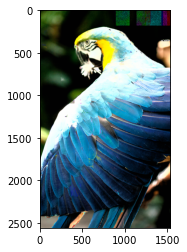

In [184]:
# fig1 = plt.figure()
plt.imshow(final_output[:,:,:])
# plt.savefig('./results/finalout.png',dpi = 1000)
# cv2.imwrite('./results/finalout.png', final_output)
# io.imsave(path.join('./results/', 'finalout.png'),final_output) 

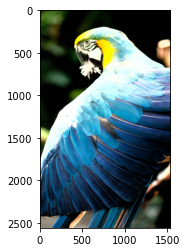

In [185]:
plt.imshow(final_output_smooth[:,:,:])
# im_gbr = cv2.cvtColor(final_output_smooth, cv2.COLOR_RGB2BGR)
# cv2.imwrite('./results/finalout_smooth.png', final_output_smooth)
# io.imsave(path.join('./results/', 'finalout_smooth.png'),final_output_smooth) 

In [186]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse <= 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [187]:
psnr(highr_output_image,final_output)

29.985767260190208

In [188]:
psnr(highr_output_image, final_output_smooth)

29.991157106330036